In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pqcd

from pqcd.utils import (
    to_GeV_per_cubic_femtometre, 
    to_nucleons_per_cubic_femtometre,
    nsat
    )

In [2]:
crust = pd.read_csv('../make-agnostic-processes/ingo-bps-with-cs2c2.csv')

In [5]:
crust

,baryon_density,pressurec2,energy_densityc2,cs2c2
0,6.690488e+00,1.123602e-13,7.757621e+00,1.694600e-11
1,7.911502e+00,1.123602e-12,7.817296e+00,1.355688e-10
2,7.961680e+00,1.123602e-11,7.857078e+00,3.304493e-10
3,8.212574e+00,1.123602e-10,8.105720e+00,3.831341e-10
4,1.169163e+01,1.346106e-09,1.153698e+01,1.670024e-09
...,...,...,...,...
73,1.070478e+14,4.951233e+11,1.079919e+14,7.578690e-03
74,1.137383e+14,5.478749e+11,1.147740e+14,7.983989e-03
75,1.204288e+14,6.034447e+11,1.215592e+14,8.402345e-03
76,1.271193e+14,6.619255e+11,1.283475e+14,8.781323e-03


In [7]:
pressure = to_GeV_per_cubic_femtometre(crust['pressurec2'].values)
energy_density = to_GeV_per_cubic_femtometre(crust['energy_densityc2'].values)
baryon_density = to_nucleons_per_cubic_femtometre(crust['baryon_density'].values)

In [10]:
chemical_potential = (energy_density+pressure)/baryon_density

In [11]:
baryon_density

array([4.02910588e-15, 4.76441780e-15, 4.79463588e-15, 4.94572757e-15,
       7.04086256e-15, 9.97203698e-15, 2.73979198e-14, 1.27924111e-13,
       6.98042611e-13, 6.34080547e-12, 1.59250400e-11, 4.00090229e-11,
       1.00485899e-10, 2.52423496e-10, 6.33979785e-10, 1.59250409e-09,
       4.00090219e-09, 5.03638230e-09, 1.00485896e-08, 2.00448016e-08,
       4.00090210e-08, 7.98165902e-08, 1.59250403e-07, 2.00448016e-07,
       3.17795714e-07, 5.03638232e-07, 6.33979814e-07, 7.98165859e-07,
       1.00485896e-06, 1.59250408e-06, 2.52423493e-06, 4.00090195e-06,
       5.03638220e-06, 6.33979791e-06, 7.98165859e-06, 1.00485900e-05,
       1.26513924e-05, 1.59250401e-05, 2.00448023e-05, 2.52423489e-05,
       3.17795726e-05, 4.00090195e-05, 5.03638220e-05, 6.33979828e-05,
       7.98165896e-05, 1.00485900e-04, 1.11304047e-04, 1.26513920e-04,
       1.59250405e-04, 2.00448019e-04, 2.59071515e-04, 2.68942813e-04,
       3.14874617e-04, 3.97974943e-04, 4.79362856e-04, 5.85429084e-04,
      

In [13]:
pressure*1000

array([6.30294481e-26, 6.30294468e-25, 6.30294468e-24, 6.30294503e-23,
       7.55110343e-22, 8.73677595e-21, 1.06090146e-19, 3.63200129e-18,
       1.18567273e-16, 6.08078460e-15, 3.10031197e-14, 1.51707179e-13,
       7.18288218e-13, 3.28631946e-12, 1.44655186e-11, 6.08770284e-11,
       2.44063796e-10, 3.28196776e-10, 8.95525439e-10, 2.39198803e-09,
       6.27806181e-09, 1.62508341e-08, 4.16625674e-08, 5.45302303e-08,
       1.01659212e-07, 1.89031444e-07, 2.57676813e-07, 3.14271324e-07,
       4.28107514e-07, 7.93795926e-07, 1.47031886e-06, 2.72215977e-06,
       3.53336258e-06, 4.80651552e-06, 6.54016881e-06, 8.89276862e-06,
       1.20943966e-05, 1.56203948e-05, 2.12430233e-05, 2.88808266e-05,
       3.71256358e-05, 5.04797952e-05, 6.86464935e-05, 9.32961246e-05,
       1.26868985e-04, 1.62073181e-04, 1.80473077e-04, 2.05311280e-04,
       2.79145234e-04, 3.62954640e-04, 4.87078690e-04, 4.92378852e-04,
       5.21211725e-04, 5.67763783e-04, 6.13512535e-04, 6.75853493e-04,
      

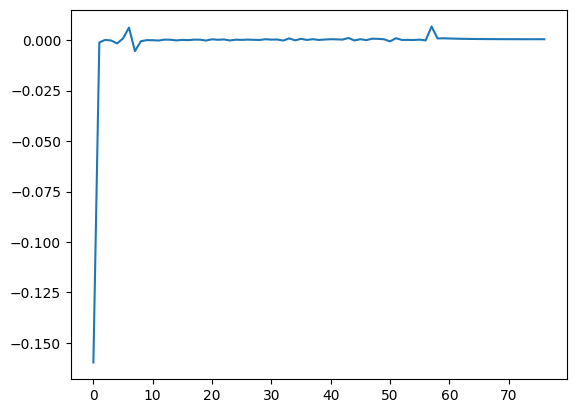

In [18]:
plt.plot(np.diff(chemical_potential))

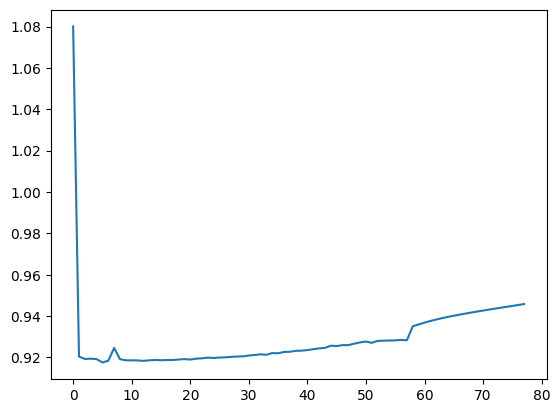

In [19]:
plt.plot(chemical_potential)